
# Project: "We Rate Dogs" Data Analysis
 
## Table of Contents
<ul>
<li><a href="#intro">Introduction</a></li>
<li><a href="#wrangling">Data Wrangling</a></li>
<li><a href="#eda">Exploratory Data Analysis</a></li>
<li><a href="#conclusions">Conclusions</a></li>
<li><a href="#reference">Reference</a></li>
</ul>

<a id='intro'></a>
# Introduction

> Twitter account 'WeRateDogs (@dog_rates)" is famous for its unique tweets which evaluate dog pictures which are posted from readers. In this analysis, we get the tweets data from Twitter API and the additional data about pictures of those tweets and assess them. Specifically, we focus on 2 topics below
>
> * How the ratings are related with stages and types of dogs.
> * Relationship between favorite counts and the ratings.

<a id='wrangling'></a>
# Data Wrangling

## Gather

In [2]:
#import packages

import pandas as pd
import numpy as np
import requests
import tweepy
import json
import timeit
import datetime
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm
%matplotlib inline

### Aquire Twitter archieve data

In [3]:
# read "twitter-archive-enhanced.csv" file
df_archive = pd.read_csv("twitter-archive-enhanced.csv")
df_archive.columns

Index(['tweet_id', 'in_reply_to_status_id', 'in_reply_to_user_id', 'timestamp',
       'source', 'text', 'retweeted_status_id', 'retweeted_status_user_id',
       'retweeted_status_timestamp', 'expanded_urls', 'rating_numerator',
       'rating_denominator', 'name', 'doggo', 'floofer', 'pupper', 'puppo'],
      dtype='object')

### Acquire image-predictions data

In [4]:
# download image prediction tsv file as "image_predictions.tsv" in the local directory
url = "https://d17h27t6h515a5.cloudfront.net/topher/2017/August/599fd2ad_image-predictions/image-predictions.tsv"
response = requests.get(url)

with open("image_predictions.tsv", mode="wb") as file:
    file.write(response.content)

In [5]:
# import the file into this notebook as a dataframe
df_image = pd.read_csv("image_predictions.tsv", sep="\t")
df_image.columns

Index(['tweet_id', 'jpg_url', 'img_num', 'p1', 'p1_conf', 'p1_dog', 'p2',
       'p2_conf', 'p2_dog', 'p3', 'p3_conf', 'p3_dog'],
      dtype='object')

### Acquire tweet json-file (from TwitterAPI) 

In [6]:
# get api using tweepy
consumer_key = "###"
consumer_secret = "###"
access_token = "###"
access_token_secret = "###"

auth = tweepy.OAuthHandler(consumer_key, consumer_secret)
auth.set_access_token(access_token, access_token_secret)
api = tweepy.API(auth)

In [11]:
# select tweets we need in api json and get "retweet_count"  and "favorite_count" information of each.
# store them in the list"data_list"
start = timeit.timeit()

data_list = []
for tweet_id in df_archive["tweet_id"]:
    try:
        api_status = api.get_status(tweet_id, tweet_mode='extended', wait_on_rate_limit=True, wait_on_rate_limit_notify=True)
        tweet_data = {}
        tweet_data["tweet_id"] = api_status._json["id"]
        tweet_data["ret"] = api_status._json["retweet_count"]
        tweet_data["fav"] = api_status._json["favorite_count"]
        data_list.append(tweet_data)
    except Exception as e:
        print(str(tweet_id) + " : " + str(e))
        
end = timeit.timeit()
print(end - start)

888202515573088257 : [{'code': 144, 'message': 'No status found with that ID.'}]
873697596434513921 : [{'code': 144, 'message': 'No status found with that ID.'}]
872668790621863937 : [{'code': 144, 'message': 'No status found with that ID.'}]
869988702071779329 : [{'code': 144, 'message': 'No status found with that ID.'}]
866816280283807744 : [{'code': 144, 'message': 'No status found with that ID.'}]


Rate limit reached. Sleeping for: 648


861769973181624320 : [{'code': 144, 'message': 'No status found with that ID.'}]
845459076796616705 : [{'code': 144, 'message': 'No status found with that ID.'}]
842892208864923648 : [{'code': 144, 'message': 'No status found with that ID.'}]
837012587749474308 : [{'code': 144, 'message': 'No status found with that ID.'}]
827228250799742977 : [{'code': 144, 'message': 'No status found with that ID.'}]
802247111496568832 : [{'code': 144, 'message': 'No status found with that ID.'}]
775096608509886464 : [{'code': 144, 'message': 'No status found with that ID.'}]
771004394259247104 : [{'code': 179, 'message': 'Sorry, you are not authorized to see this status.'}]
770743923962707968 : [{'code': 144, 'message': 'No status found with that ID.'}]
754011816964026368 : [{'code': 144, 'message': 'No status found with that ID.'}]


Rate limit reached. Sleeping for: 647
Rate limit reached. Sleeping for: 563


0.002290688003995456


In [59]:
#  write the list in 'tweet_json.txt' (each element of tweet on each line in the file)
with open('tweet_json.txt', 'w') as file:
    for line in data_list:  
        json.dump(line, file)
        file.write("\n")

In [7]:
# load 'tweet_json.txt' and store it in the list "json_list" (each element of this list is a json data of each tweet)
# this list should be the same as the list"data_list"
json_list = []
with open('tweet_json.txt','r') as file:
    for line in file:
        json_list.append(json.loads(line))

In [8]:
# construct dataframe from the list "json_list" and sort columns
df_api = pd.DataFrame(json_list)
df_api = df_api.iloc[:,[1,0,2]]
df_api.columns

Index(['ret', 'fav', 'tweet_id'], dtype='object')

## Assess

In [9]:
# visual assessment
df_archive.head(5)

tweet_id  in_reply_to_status_id  in_reply_to_user_id  \
0  892420643555336193                    NaN                  NaN   
1  892177421306343426                    NaN                  NaN   
2  891815181378084864                    NaN                  NaN   
3  891689557279858688                    NaN                  NaN   
4  891327558926688256                    NaN                  NaN   

                   timestamp  \
0  2017-08-01 16:23:56 +0000   
1  2017-08-01 00:17:27 +0000   
2  2017-07-31 00:18:03 +0000   
3  2017-07-30 15:58:51 +0000   
4  2017-07-29 16:00:24 +0000   

                                              source  \
0  <a href="http://twitter.com/download/iphone" r...   
1  <a href="http://twitter.com/download/iphone" r...   
2  <a href="http://twitter.com/download/iphone" r...   
3  <a href="http://twitter.com/download/iphone" r...   
4  <a href="http://twitter.com/download/iphone" r...   

                                                text  retweeted_status_id  \
0  This is Phineas. He's a mystical boy. Only eve...                  NaN   
1  This is Tilly. She's just checking pup on you....                  NaN   
2  This is Archie. He is a rare Norwegian Pouncin...                  NaN   
3  This is Darla. She commenced a snooze mid meal...                  NaN   
4  This is Franklin. He would like you to stop ca...                  NaN   

   retweeted_status_user_id retweeted_status_timestamp  \
0                       NaN                        NaN   
1                       NaN                        NaN   
2                       NaN                        NaN   
3                       NaN                        NaN   
4                       NaN                        NaN   

                                       expanded_urls  rating_numerator  \
0  https://twitter.com/dog_rates/status/892420643...                13   
1  https://twitter.com/dog_rates/status/892177421...                13   
2  https://twitter.com/dog_rates/status/891815181...                12   
3  https://twitter.com/dog_rates/status/891689557...                13   
4  https://twitter.com/dog_rates/status/891327558...                12   

   rating_denominator      name doggo floofer pupper puppo  
0                  10   Phineas  None    None   None  None  
1                  10     Tilly  None    None   None  None  
2                  10    Archie  None    None   None  None  
3                  10     Darla  None    None   None  None  
4                  10  Franklin  None    None   None  None

In [10]:
df_archive.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2356 entries, 0 to 2355
Data columns (total 17 columns):
tweet_id                      2356 non-null int64
in_reply_to_status_id         78 non-null float64
in_reply_to_user_id           78 non-null float64
timestamp                     2356 non-null object
source                        2356 non-null object
text                          2356 non-null object
retweeted_status_id           181 non-null float64
retweeted_status_user_id      181 non-null float64
retweeted_status_timestamp    181 non-null object
expanded_urls                 2297 non-null object
rating_numerator              2356 non-null int64
rating_denominator            2356 non-null int64
name                          2356 non-null object
doggo                         2356 non-null object
floofer                       2356 non-null object
pupper                        2356 non-null object
puppo                         2356 non-null object
dtypes: float64(4), int64(3), ob

In [11]:
# visual assessment
df_api.sample(5)

ret    fav            tweet_id
686   3432  10145  786595970293370880
1584  1259   3303  686034024800862208
1734   734   2372  679047485189439488
1939   253    737  673656262056419329
1353  1028   3036  702539513671897089

In [12]:
df_api.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2341 entries, 0 to 2340
Data columns (total 3 columns):
ret         2341 non-null int64
fav         2341 non-null int64
tweet_id    2341 non-null int64
dtypes: int64(3)
memory usage: 54.9 KB


In [13]:
# visual assessment
df_image.sample(5)

tweet_id                                            jpg_url  \
1215  743510151680958465  https://pbs.twimg.com/ext_tw_video_thumb/74350...   
1522  788070120937619456    https://pbs.twimg.com/media/Co-hmcYXYAASkiG.jpg   
649   681891461017812993    https://pbs.twimg.com/media/CXaQqGbWMAAKEgN.jpg   
1491  782747134529531904    https://pbs.twimg.com/media/CtzgXgeXYAA1Gxw.jpg   
845   695095422348574720    https://pbs.twimg.com/media/CaV5mRDXEAAR8iG.jpg   

      img_num                p1   p1_conf  p1_dog              p2   p2_conf  \
1215        1          sea_lion  0.859046   False             tub  0.020405   
1522        1  golden_retriever  0.735163    True  Sussex_spaniel  0.064897   
649         1         Chihuahua  0.203570    True         doormat  0.134316   
1491        1  golden_retriever  0.560699    True      otterhound  0.199482   
845         1          papillon  0.227784    True       Chihuahua  0.218128   

      p2_dog                  p3   p3_conf  p3_dog  
1215   False        hippopotamus  0.013095   False  
1522    True  Labrador_retriever  0.047704    True  
649    False         toy_terrier  0.084482    True  
1491    True             clumber  0.040682    True  
845     True       Border_collie  0.093457    True

In [14]:
df_image.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2075 entries, 0 to 2074
Data columns (total 12 columns):
tweet_id    2075 non-null int64
jpg_url     2075 non-null object
img_num     2075 non-null int64
p1          2075 non-null object
p1_conf     2075 non-null float64
p1_dog      2075 non-null bool
p2          2075 non-null object
p2_conf     2075 non-null float64
p2_dog      2075 non-null bool
p3          2075 non-null object
p3_conf     2075 non-null float64
p3_dog      2075 non-null bool
dtypes: bool(3), float64(3), int64(2), object(4)
memory usage: 152.1+ KB


### Quality
#### df_archive table
* "timestamp" is a string not a datetime.
* Rows of tweets which are later than 08/01 2017 should be removed.
* Tweets which are original ratings should be extracted. 
* "name" column are unreliable, thus it should be delete.
* 'rating_numerator' and 'rating_denominator' columns are not necessarily correctly extracted.
* 'rating' column which represents ('rating_numerator / rating_denominator) should be created.
* Stage columns ('doggo', 'floofer','pupper', 'puppo') are not necessarily correctly extracted.

#### df_image table
* Some pictures are predicted not as dogs. If a picture is not predicted as dog till the 3rd prediction, delete that row.

### Tidiness
* "df_api" and "df_image" should be merged to "df_archive"
* Dog stages in the archive data should be in 1 column.
* We need only the most primary confident prediction of dog types from pictures, so make the column "predicted dog type" in place of p1~p3 predictions.

## Clean

In [15]:
# copy the dataframes for the following cleanness
archive_clean = df_archive.copy()
image_clean = df_image.copy()
api_clean = df_api.copy()

### Tweets which are original should be extracted from archive table.

In [16]:
# use .query method to extract rows whose both "in_reply_to_status_id" and "retweeted_status_id" are NaN
archive_clean = archive_clean[archive_clean.in_reply_to_status_id.isnull() & archive_clean.retweeted_status_id.isnull()]
archive_clean.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2097 entries, 0 to 2355
Data columns (total 17 columns):
tweet_id                      2097 non-null int64
in_reply_to_status_id         0 non-null float64
in_reply_to_user_id           0 non-null float64
timestamp                     2097 non-null object
source                        2097 non-null object
text                          2097 non-null object
retweeted_status_id           0 non-null float64
retweeted_status_user_id      0 non-null float64
retweeted_status_timestamp    0 non-null object
expanded_urls                 2094 non-null object
rating_numerator              2097 non-null int64
rating_denominator            2097 non-null int64
name                          2097 non-null object
doggo                         2097 non-null object
floofer                       2097 non-null object
pupper                        2097 non-null object
puppo                         2097 non-null object
dtypes: float64(4), int64(3), object(10)

In [17]:
# remove columns related to "in_reply_status" or "retweeted_status" which is no longer necessary
archive_clean = archive_clean.drop(columns=["in_reply_to_status_id","in_reply_to_user_id",
                            "retweeted_status_id","retweeted_status_user_id","retweeted_status_timestamp"])

In [18]:
# check columns
archive_clean.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2097 entries, 0 to 2355
Data columns (total 12 columns):
tweet_id              2097 non-null int64
timestamp             2097 non-null object
source                2097 non-null object
text                  2097 non-null object
expanded_urls         2094 non-null object
rating_numerator      2097 non-null int64
rating_denominator    2097 non-null int64
name                  2097 non-null object
doggo                 2097 non-null object
floofer               2097 non-null object
pupper                2097 non-null object
puppo                 2097 non-null object
dtypes: int64(3), object(9)
memory usage: 213.0+ KB


In [19]:
archive_clean.columns

Index(['tweet_id', 'timestamp', 'source', 'text', 'expanded_urls',
       'rating_numerator', 'rating_denominator', 'name', 'doggo', 'floofer',
       'pupper', 'puppo'],
      dtype='object')

### "name" column in archive data is not necessarily in this analysis so delete this.

In [20]:
# use drop() method
archive_clean = archive_clean.drop(columns="name")

In [21]:
# confirm that there is no column named "name" now.
assert "name" not in archive_clean.columns

### "timestamp" in archive data is a string not a datetime.

In [22]:
# use pd.to_datetime() function to convert the data type.
archive_clean.timestamp = pd.to_datetime(archive_clean.timestamp)

In [23]:
# confirm it was converted properly and the term in it is possible
archive_clean.timestamp.describe()

count                    2097
unique                   2097
top       2016-09-12 15:10:21
freq                        1
first     2015-11-15 22:32:08
last      2017-08-01 16:23:56
Name: timestamp, dtype: object

### Rows of tweets which are later than 08/01 2017 should be removed from archive data.

In [24]:
# use query() method to extract rows 
archive_clean = archive_clean.query('timestamp < datetime.date(2017, 8, 1)')

In [25]:
# confirm the latest tweet information in archive data is earlier than  08/01 2017
archive_clean.timestamp.describe()

count                    2095
unique                   2095
top       2016-09-12 15:10:21
freq                        1
first     2015-11-15 22:32:08
last      2017-07-31 00:18:03
Name: timestamp, dtype: object

### 'rating_numerator' and 'rating_denominator' columns in archive data are not necessarily correctly extracted.

#### Definition

> We take a look at "text" column in the archieve data. We can assume that ratings are in the form of fractions, so extract the fractions as ratings.
>
> However, we will assess texts of tweets visually in the case where the texts have 2 or more fractions.
>
> When we find that there are 2 or more different dogs' ratings in 1 tweet in this process, delete the tweet because it can be misguiding.

In [26]:
# Firstly, extract the first fraction which appears in the "text" and confirm that we could do it from all rows.
fractions = archive_clean.text.str.extract(r'([0-9]+[.]*[0-9]*[/][0-9]+)')
fractions.isnull().sum()

0    0
dtype: int64

In [27]:
# split the fractions into numerators and denominators
f_nume, f_deno = fractions.iloc[:,0].str.split("/").str
archive_clean.rating_numerator = f_nume.astype(float)
archive_clean.rating_denominator = f_deno.astype(float)
archive_clean.rating_denominator.dtype

dtype('float64')

In [28]:
# extract fractions from "text" column using .str.extractall().
# If there are 2 or more than "text" column, assess each row one by one.
pd.options.display.max_colwidth = 150

ratings = archive_clean.text.str.extractall(r'([0-9]+[.]*[0-9]*[/][0-9]+)')

list_duplicated = []    # list of index whose rows have 2 or more fractions  the "text"
for multi_index in ratings.index:
    if multi_index[1] != 0:
        list_duplicated.append(multi_index[0])
        
print(list_duplicated)
archive_clean.info()

[766, 1007, 1068, 1165, 1202, 1222, 1359, 1459, 1465, 1508, 1525, 1538, 1662, 1795, 1832, 1897, 1901, 1970, 2010, 2010, 2064, 2113, 2177, 2216, 2263, 2272, 2306, 2335]
<class 'pandas.core.frame.DataFrame'>
Int64Index: 2095 entries, 2 to 2355
Data columns (total 11 columns):
tweet_id              2095 non-null int64
timestamp             2095 non-null datetime64[ns]
source                2095 non-null object
text                  2095 non-null object
expanded_urls         2092 non-null object
rating_numerator      2095 non-null float64
rating_denominator    2095 non-null float64
doggo                 2095 non-null object
floofer               2095 non-null object
pupper                2095 non-null object
puppo                 2095 non-null object
dtypes: datetime64[ns](1), float64(2), int64(1), object(7)
memory usage: 196.4+ KB


In [29]:
# assess each row one by one
archive_clean.text[list_duplicated]

766                                     "Yep... just as I suspected. You're not flossing." 12/10 and 11/10 for the pup not flossing https://t.co/SuXcI9B7pQ
1007                       This is Bookstore and Seaweed. Bookstore is tired and Seaweed is an asshole. 10/10 and 7/10 respectively https://t.co/eUGjGjjFVJ
1068           After so many requests, this is Bretagne. She was the last surviving 9/11 search dog, and our second ever 14/10. RIP https://t.co/XAVDNDaVgQ
1165                                                                                       Happy 4/20 from the squad! 13/10 for all https://t.co/eV1diwds8a
1202                                  This is Bluebert. He just saw that both #FinalFur match ups are split 50/50. Amazed af. 11/10 https://t.co/Kky1DPG4iq
1222       Meet Travis and Flurp. Travis is pretty chill but Flurp can't lie down properly. 10/10 &amp; 8/10\nget it together Flurp https://t.co/Akzl5ynMmE
1359                 This is Socks. That water pup w the super l

In [30]:
def put_ratings(index, numerator, denomenator):
    archive_clean.ix[index,"rating_denominator"] = denomenator
    archive_clean.ix[index,"rating_numerator"] = numerator

indexes_to_be_deleted = [766, 1007, 1165, 1222, 1459, 1525,1538,1795,1832,1901,2113,2177,2216,2272,2306]
archive_clean = archive_clean.drop(index = indexes_to_be_deleted)

put_ratings(1068,14,10)
put_ratings(1202,11,10)
put_ratings(1359,9,10)
put_ratings(1465,10,10)
put_ratings(1508,10,10)
put_ratings(1662,10,10)
put_ratings(1897,10,10)
put_ratings(1970,8,10)
put_ratings(2010,10,10)
put_ratings(2064,11,10)
put_ratings(2263,10,10)
put_ratings(2335, 9,10)

archive_clean.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2080 entries, 2 to 2355
Data columns (total 11 columns):
tweet_id              2080 non-null int64
timestamp             2080 non-null datetime64[ns]
source                2080 non-null object
text                  2080 non-null object
expanded_urls         2077 non-null object
rating_numerator      2080 non-null float64
rating_denominator    2080 non-null float64
doggo                 2080 non-null object
floofer               2080 non-null object
pupper                2080 non-null object
puppo                 2080 non-null object
dtypes: datetime64[ns](1), float64(2), int64(1), object(7)
memory usage: 275.0+ KB


/anaconda3/lib/python3.6/site-packages/ipykernel/__main__.py:2: DeprecationWarning: 
.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#ix-indexer-is-deprecated
  from ipykernel import kernelapp as app
/anaconda3/lib/python3.6/site-packages/ipykernel/__main__.py:3: DeprecationWarning: 
.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#ix-indexer-is-deprecated
  app.launch_new_instance()


### 'rating' column which represents ('rating_numerator / rating_denominator) should be created.

In [31]:
# create a new column called "rating" and drop 'rating_numerator' and 'rating_denominator'.
archive_clean["rating"] = archive_clean.rating_numerator / archive_clean.rating_denominator 
archive_clean = archive_clean.drop(columns=['rating_numerator','rating_denominator'])
archive_clean.columns

Index(['tweet_id', 'timestamp', 'source', 'text', 'expanded_urls', 'doggo',
       'floofer', 'pupper', 'puppo', 'rating'],
      dtype='object')

In [32]:
# Also, I will check "rating" extremely high or low and remove unappropriate ones.
archive_clean[(archive_clean.rating < 0.1) | (archive_clean.rating > 2.)].text

315                                         When you're so blinded by your systematic plagiarism that you forget what day it is. 0/10 https://t.co/YbEJPkg4Ag
516     Meet Sam. She smiles 24/7 &amp; secretly aspires to be a reindeer. \nKeep Sam smiling by clicking and sharing this link:\nhttps://t.co/98tB8y7y7t ...
979                                                                            This is Atticus. He's quite simply America af. 1776/10 https://t.co/GRXwMxLBkh
2074                                                                      After so many requests... here you go.\n\nGood dogg. 420/10 https://t.co/yfAAo1gdeY
Name: text, dtype: object

In [33]:
# We delete tweet whose picture are not dogs.
archive_clean = archive_clean.drop([315, 516, 2074])
archive_clean.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2077 entries, 2 to 2355
Data columns (total 10 columns):
tweet_id         2077 non-null int64
timestamp        2077 non-null datetime64[ns]
source           2077 non-null object
text             2077 non-null object
expanded_urls    2074 non-null object
doggo            2077 non-null object
floofer          2077 non-null object
pupper           2077 non-null object
puppo            2077 non-null object
rating           2077 non-null float64
dtypes: datetime64[ns](1), float64(1), int64(1), object(7)
memory usage: 178.5+ KB


### Stage columns ('doggo', 'floofer','pupper', 'puppo') in archive are not necessarily correctly extracted.

In [34]:
# First, delete these columns
archive_clean = archive_clean.drop(columns = ['doggo', 'floofer','pupper', 'puppo'])
archive_clean.columns

Index(['tweet_id', 'timestamp', 'source', 'text', 'expanded_urls', 'rating'], dtype='object')

In [35]:
# add the new column of each stage (boolean)
archive_clean["doggo"] = archive_clean.text.str.contains("doggo")
archive_clean["pupper"] = archive_clean.text.str.contains("pupper")
archive_clean["puppo"] = archive_clean.text.str.contains("puppo")
archive_clean["floof"] = archive_clean.text.str.contains("floof")
archive_clean["snoot"] = archive_clean.text.str.contains("snoot")
archive_clean["blep"] = archive_clean.text.str.contains("blep")

archive_clean[['doggo','pupper', 'puppo','floof','snoot', 'blep']].sum()

doggo      84
pupper    245
puppo      29
floof      23
snoot       0
blep        1
dtype: int64

In [36]:
# assess the rows which has 2 or more stage name in the "text" column.

archive_clean.text[archive_clean[['doggo','pupper', 'puppo','floof','snoot', 'blep']].sum(axis="columns") > 1]

172     I have stumbled puppon a doggo painting party. They're looking to be the next Pupcasso or Puppollock. All 13/10 would put it on the fridge https:/...
191     Here's a puppo participating in the #ScienceMarch. Cleverly disguising her own doggo agenda. 13/10 would keep the planet habitable for https://t.c...
531          Here we have Burke (pupper) and Dexter (doggo). Pupper wants to be exactly like doggo. Both 12/10 would pet at same time https://t.co/ANBpEYHaho
575          This is Bones. He's being haunted by another doggo of roughly the same size. 12/10 deep breaths pupper everything's fine https://t.co/55Dqe0SJNj
705     This is Pinot. He's a sophisticated doggo. You can tell by the hat. Also pointier than your average pupper. Still 10/10 would pet cautiously https...
889          Meet Maggie &amp; Lila. Maggie is the doggo, Lila is the pupper. They are sisters. Both 12/10 would pet at the same time https://t.co/MYwR4DQKll
956                  Please stop sending it pictures

In [37]:
# read each text and choose the most appropriate stage.
# If we find that there are 2 dogs in the picture and thus there are 2 stages, delete the row.
# This is because these rows can mis leading when we consider them with image prediction data.

def cancel_stage(index, stage):
    archive_clean.ix[index, stage] = False
    
indexes_to_be_deleted2 = [531, 889, 1062, 1113]
archive_clean = archive_clean.drop(index = indexes_to_be_deleted2)

cancel_stage(172, "puppo")
cancel_stage(191, "doggo")
cancel_stage(575, "doggo")
cancel_stage(705, "pupper")
cancel_stage(956, "doggo")
cancel_stage(1063, "pupper")

/anaconda3/lib/python3.6/site-packages/ipykernel/__main__.py:6: DeprecationWarning: 
.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#ix-indexer-is-deprecated


In [38]:
# confirm that there is no row which has 2 or more stages
assert len(archive_clean[archive_clean[['doggo','pupper', 'puppo','floof','snoot', 'blep']].sum(axis="columns") > 1]) == 0

### Dog stages in the archive data should be in 1 column.
> First, we separate the rows into those which is given stages(df"have_stage_tweets") if dog and those which are not(df"no_stage_tweets").
> 
> * For df"no_stage_tweets", we give a "stage" colunn which stores "NaN".  
> * For df"have_stage_tweets", we give a "stage" colunn which stores the name of stage.
>
> Finally, we concatabnate these dataframes to get the final dataframe.

In [39]:
# extract the rows which are not assignes dos stages as "no_stage_tweets".
# construct new column named "stage" which is stored NaN and delete unnecessary columns.

no_stage_tweets = archive_clean[archive_clean[['doggo','pupper', 'puppo','floof','snoot','blep']].sum(axis="columns") == 0]
no_stage_tweets = no_stage_tweets.drop(columns = ['doggo','pupper', 'puppo','floof','snoot','blep'])
no_stage_tweets["stage"] = np.nan
no_stage_tweets.columns

Index(['tweet_id', 'timestamp', 'source', 'text', 'expanded_urls', 'rating',
       'stage'],
      dtype='object')

In [40]:
# extract the rows which are assignes any dos stages as "have_stage_tweets".
# construct new column named "stage"  and delete unnecessary columns (using .melt() method).

have_stage_tweets = archive_clean[archive_clean[['doggo','pupper', 'puppo','floof','snoot','blep']].sum(axis="columns") >= 1]

## consirm that all rows are in df"no_stage_tweets" or df"have_stage_tweets".
assert len(no_stage_tweets) + len(have_stage_tweets) == len(archive_clean)

have_stage_tweets = have_stage_tweets.melt(id_vars=['tweet_id', 'timestamp', 'source', 'text', 'expanded_urls', 'rating'], var_name="stage")
have_stage_tweets = have_stage_tweets[have_stage_tweets.value == True]
have_stage_tweets = have_stage_tweets.drop(columns = 'value')
have_stage_tweets

## confirm that df"no_stage_tweets" or df"have_stage_tweets" and same columns.
no_stage_tweets.columns == have_stage_tweets.columns

array([ True,  True,  True,  True,  True,  True,  True])

In [41]:
# concatanate df"no_stage_tweets" or df"have_stage_tweets" 
archive_clean2 = pd.concat([no_stage_tweets, have_stage_tweets]).sort_index().reset_index(drop=True)
assert len(archive_clean2) == len(archive_clean)

pd.options.display.max_colwidth = 30
archive_clean2.head()

## reset index
archive_clean2 = archive_clean2.reset_index(drop=True)
archive_clean2.head()

tweet_id           timestamp                         source  \
0  890240255349198849 2017-07-26 15:59:51  <a href="http://twitter.co...   
1  891815181378084864 2017-07-31 00:18:03  <a href="http://twitter.co...   
2  891689557279858688 2017-07-30 15:58:51  <a href="http://twitter.co...   
3  891327558926688256 2017-07-29 16:00:24  <a href="http://twitter.co...   
4  884162670584377345 2017-07-09 21:29:42  <a href="http://twitter.co...   

                            text                  expanded_urls  rating  stage  
0  This is Cassie. She is a c...  https://twitter.com/dog_ra...     1.4  doggo  
1  This is Archie. He is a ra...  https://twitter.com/dog_ra...     1.2    NaN  
2  This is Darla. She commenc...  https://twitter.com/dog_ra...     1.3    NaN  
3  This is Franklin. He would...  https://twitter.com/dog_ra...     1.2    NaN  
4  Meet Yogi. He doesn't have...  https://twitter.com/dog_ra...     1.2  doggo

### Some pictures are predicted not as dogs. If a picture is not predicted as dog till the 3rd prediction, delete that row in prediction image data.

In [42]:
# use .query() method to extract rows of tweets which are predicted as dogs
image_clean = image_clean.query(' p1_dog == True | p2_dog == True | p3_dog == True ')

In [43]:
# confirm there is no row which is not predicted as dogs either in p1~p3 predictions
assert ( (image_clean.p1_dog | image_clean.p2_dog | image_clean.p3_dog)==0 ).sum() == 0
image_clean.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1751 entries, 0 to 2073
Data columns (total 12 columns):
tweet_id    1751 non-null int64
jpg_url     1751 non-null object
img_num     1751 non-null int64
p1          1751 non-null object
p1_conf     1751 non-null float64
p1_dog      1751 non-null bool
p2          1751 non-null object
p2_conf     1751 non-null float64
p2_dog      1751 non-null bool
p3          1751 non-null object
p3_conf     1751 non-null float64
p3_dog      1751 non-null bool
dtypes: bool(3), float64(3), int64(2), object(4)
memory usage: 141.9+ KB


### We need only the most primary confident prediction of dog types from pictures, so make the column "predicted dog type" in place of p1~p3 predictions.

In [44]:
# create a new list of dog types according to p1 ~p3.
# add new column "dog_type" in df"image_clean" using it.


image_clean = image_clean.reset_index(drop=True )
dog_type_list = []

for index in image_clean.index:
    if image_clean.p1_dog.iloc[index] == True:
        dog_type_list.append(image_clean.p1.iloc[index])
    elif image_clean.p2_dog.iloc[index] == True:
        dog_type_list.append(image_clean.p2.iloc[index])
    elif image_clean.p3_dog.iloc[index] == True:
        dog_type_list.append(image_clean.p3.iloc[index])
    else:
        raise   # throw an error when there is no dog type predicted in p1~p3
        
        
image_clean["dog_type"] = dog_type_list

In [45]:
# remove p1~p3 columns because the are no longer needed.
image_clean = image_clean.drop(columns = ["p1","p1_conf","p1_dog","p2","p2_conf","p2_dog","p3","p3_conf","p3_dog"])

In [46]:
# confirm the columns
image_clean.head()

tweet_id                        jpg_url  img_num  \
0  666020888022790149  https://pbs.twimg.com/medi...        1   
1  666029285002620928  https://pbs.twimg.com/medi...        1   
2  666033412701032449  https://pbs.twimg.com/medi...        1   
3  666044226329800704  https://pbs.twimg.com/medi...        1   
4  666049248165822465  https://pbs.twimg.com/medi...        1   

                 dog_type  
0  Welsh_springer_spaniel  
1                 redbone  
2         German_shepherd  
3     Rhodesian_ridgeback  
4      miniature_pinscher

### "df_api" and "df_image" should be merged to "df_archive"

In [47]:
# use inner merge to merge 3 dataframes to make final dataframe "df"

df = archive_clean2.merge(api_clean)
df = df.merge(image_clean)
df.head()

tweet_id           timestamp                         source  \
0  890240255349198849 2017-07-26 15:59:51  <a href="http://twitter.co...   
1  891815181378084864 2017-07-31 00:18:03  <a href="http://twitter.co...   
2  891689557279858688 2017-07-30 15:58:51  <a href="http://twitter.co...   
3  891327558926688256 2017-07-29 16:00:24  <a href="http://twitter.co...   
4  884162670584377345 2017-07-09 21:29:42  <a href="http://twitter.co...   

                            text                  expanded_urls  rating  \
0  This is Cassie. She is a c...  https://twitter.com/dog_ra...     1.4   
1  This is Archie. He is a ra...  https://twitter.com/dog_ra...     1.2   
2  This is Darla. She commenc...  https://twitter.com/dog_ra...     1.3   
3  This is Franklin. He would...  https://twitter.com/dog_ra...     1.2   
4  Meet Yogi. He doesn't have...  https://twitter.com/dog_ra...     1.2   

   stage   ret    fav                        jpg_url  img_num  \
0  doggo  7300  31555  https://pbs.twimg.com/medi...        1   
1    NaN  4102  24746  https://pbs.twimg.com/medi...        1   
2    NaN  8540  41677  https://pbs.twimg.com/medi...        1   
3    NaN  9265  39842  https://pbs.twimg.com/medi...        2   
4  doggo  2952  20137  https://pbs.twimg.com/medi...        1   

             dog_type  
0            Pembroke  
1           Chihuahua  
2  Labrador_retriever  
3              basset  
4     German_shepherd

In [48]:
# confirm final dataframe
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1645 entries, 0 to 1644
Data columns (total 12 columns):
tweet_id         1645 non-null int64
timestamp        1645 non-null datetime64[ns]
source           1645 non-null object
text             1645 non-null object
expanded_urls    1645 non-null object
rating           1645 non-null float64
stage            287 non-null object
ret              1645 non-null int64
fav              1645 non-null int64
jpg_url          1645 non-null object
img_num          1645 non-null int64
dog_type         1645 non-null object
dtypes: datetime64[ns](1), float64(1), int64(4), object(6)
memory usage: 167.1+ KB


## Store

In [49]:
# store the final dataframe "df" in the csv file.
df.to_csv("twitter_archieve_master.csv", index=False)

<a id='eda'></a>
# Exploratory Data Analysis

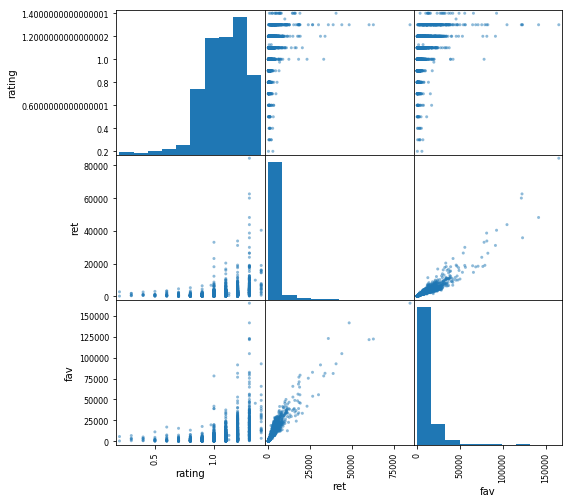

In [50]:
pd.plotting.scatter_matrix(df.iloc[:,5:9], figsize=(8,8));

### Topic1.  How the ratings are related with stages and types of dogs
> It can be possible that a master of the account has personal preference of dog stages or dog types and the rating is somehow biased. We take a look at the realtionship between dog ratings, stages, and types.
>
> First, we visualize the relationship between dog stages and ratings. The dog stage "blep" has only 1 tweet, so we ignore this stage.

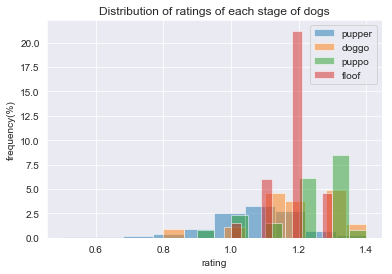

In [51]:
sns.set_style("darkgrid")

# visualize each stage's distribution
df[df.stage == "pupper"]["rating"].hist(density=1, alpha=0.5, label="pupper")
df[df.stage == "doggo"]["rating"].hist(density=1,alpha=0.5, label="doggo")
df[df.stage == "puppo"]["rating"].hist(density=1, alpha=0.5, label="puppo")
df[df.stage == "floof"]["rating"].hist(density=1, alpha=0.5, label="floof")
plt.title("Distribution of ratings of each stage of dogs")
plt.xlabel("rating")
plt.ylabel("frequency(%)")
plt.legend();

> What we have found is that there seems to be a little effect on the ratings depending on the stage of dogs. The graph suggests that the stage "puppo" tend to have the highest rating, followed by "floof", "doggo", and "pupper".
>
> Next, we visualize the relationship between dog types and ratings. We begin by knowing dog type categpry names.

In [52]:
# get to know the dog type categories
df.dog_type.value_counts().sort_values(ascending=False).head(10)

golden_retriever      152
Labrador_retriever    106
Pembroke               93
Chihuahua              87
pug                    62
toy_poodle             50
chow                   48
Samoyed                42
Pomeranian             41
malamute               33
Name: dog_type, dtype: int64

> There are too many types of dogs, so we focus only on the 5 most types which are "golden_retriever", "Labrador_retriever", "Pembroke", "Chihuahua", and "pug".

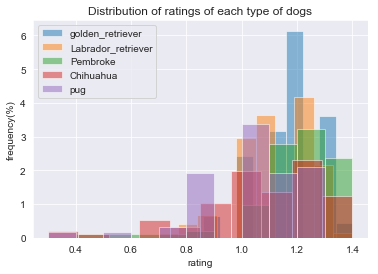

In [53]:
# visualize each type's distribution
df[df.dog_type == "golden_retriever"]["rating"].hist(density=1, alpha=0.5, label="golden_retriever")
df[df.dog_type == "Labrador_retriever"]["rating"].hist(density=1,alpha=0.5, label="Labrador_retriever")
df[df.dog_type == "Pembroke"]["rating"].hist(density=1, alpha=0.5, label="Pembroke")
df[df.dog_type == "Chihuahua"]["rating"].hist(density=1, alpha=0.5, label="Chihuahua")
df[df.dog_type == "pug"]["rating"].hist(density=1, alpha=0.5, label="pug")
plt.title("Distribution of ratings of each type of dogs")
plt.xlabel("rating")
plt.ylabel("frequency(%)")
plt.legend();

> Appearent gaps have not found between types, but "pug" seems to tend to get rather low ratings.
>
> Now we use multiple linear model for the relationship between ratings and the combination of stages and columns. (In this project, let me skip to check if this really has no problem in terms of multicollinearity .etc.)
> We set "pupper" and "pug" as baselines and see if the differences of ratings from other each stage or types are statistically significant or not.

In [54]:
# extract rows which are given both specific stage and type
df2 = df.copy()
df2 = df2[df2.stage.isin(["puppo","pupper","doggo","floof"])]
df2 = df2[df2.dog_type.isin(["golden_retriever","Labrador_retriever","Pembroke","Chihuahua","pug"])]

# add intercept and dummy columns of dog stages and types
df2["intercept"] = 1.
df2[["doggo","floof","pupper","puppo"]] = pd.get_dummies(df2.stage)
df2[["Chihuahua","Labrador_retriever","Pembroke","golden_retriever","pug"]] = pd.get_dummies(df2.dog_type)
df2.sample(3)

tweet_id           timestamp                         source  \
466  690959652130045952 2016-01-23 18:09:53  <a href="http://twitter.co...   
49   829449946868879360 2017-02-08 22:00:52  <a href="http://twitter.co...   
539  679828447187857408 2015-12-24 00:58:27  <a href="http://twitter.co...   

                              text                  expanded_urls  rating  \
466  This golden is happy to re...  https://twitter.com/dog_ra...     1.1   
49   Here's a stressed doggo. H...  https://twitter.com/dog_ra...     1.1   
539  Everybody look at this bea...  https://twitter.com/dog_ra...     1.3   

      stage    ret    fav                        jpg_url ...   intercept  \
466  pupper   1354   3795  https://pbs.twimg.com/medi... ...         1.0   
49    doggo   2211  11119  https://pbs.twimg.com/medi... ...         1.0   
539  pupper  15137  38234  https://pbs.twimg.com/medi... ...         1.0   

    doggo  floof  pupper  puppo  Chihuahua  Labrador_retriever  Pembroke  \
466     0      0       1      0          0                   0         0   
49      1      0       0      0          0                   1         0   
539     0      0       1      0          1                   0         0   

     golden_retriever  pug  
466                 1    0  
49                  0    0  
539                 0    0  

[3 rows x 22 columns]

In [55]:
# apply multiple linear regression model
lm = sm.OLS(df2.rating, df2[["intercept","doggo","floof","puppo","Chihuahua","Labrador_retriever","Pembroke","golden_retriever"]])
results = lm.fit()
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                 rating   R-squared:                       0.274
Model:                            OLS   Adj. R-squared:                  0.212
Method:                 Least Squares   F-statistic:                     4.425
Date:                Fri, 12 Oct 2018   Prob (F-statistic):           0.000326
Time:                        10:33:06   Log-Likelihood:                 75.298
No. Observations:                  90   AIC:                            -134.6
Df Residuals:                      82   BIC:                            -114.6
Df Model:                           7                                         
Covariance Type:            nonrobust                                         
======================================================================================
                         coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------
intercept              1.0182      0.033     30.753      0.000       0.952       1.084
doggo                  0.0900      0.029      3.053      0.003       0.031       0.149
floof                  0.0287      0.049      0.589      0.558      -0.068       0.126
puppo                  0.0622      0.045      1.371      0.174      -0.028       0.152
Chihuahua              0.1174      0.050      2.358      0.021       0.018       0.216
Labrador_retriever     0.1015      0.044      2.329      0.022       0.015       0.188
Pembroke               0.1618      0.045      3.631      0.000       0.073       0.251
golden_retriever       0.1237      0.040      3.098      0.003       0.044       0.203
==============================================================================
Omnibus:                        4.612   Durbin-Watson:                   1.713
Prob(Omnibus):                  0.100   Jarque-Bera (JB):                3.882
Skew:                          -0.463   Prob(JB):                        0.144
Kurtosis:                       3.423   Cond. No.                         8.12
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

> This results suggests that (in terms of dog stages) "doggo" has statistically significant difference from "pupper" and that (in terms of dog types) each of "Chihuahua","Labrador_retriever","Pembroke","golden_retriever" has statistically significant difference from "pug".
>
> Also, it can be said that 27.4% of rating evaluation can be "explained" by these 2 factors.

### Answer1. Relationship between stages of dogs and the ratings.


* Regarding dog stages, it is statsistically significant that "doggo" tend to get better ratings than "pupper".
* Regarding dog types, it is statsistically significant that "Chihuahua", "Labrador_retriever", "Pembroke", and "golden_retriever" tend to get better ratings than "pupper".  
* 27.4% of rating evaluation juege depends on these 2 factors.

### Topic2. Relationship between favorite counts and the ratings
> In this data, we have 2 indicators that show reader's preference on tweets, which are "favorite" counts and "retweet" counts. 
> It is easily predictable that tweets with high ratings are favored and also retweeted more and also that there is a strong positive correlationship between "favorite" counts and "retweet" counts. First, this should be checked.

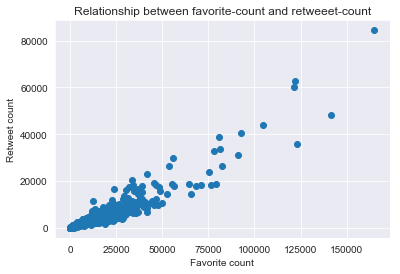

In [56]:
plt.scatter(df.fav, df.ret)
plt.title("Relationship between favorite-count and retweeet-count" )
plt.xlabel("Favorite count")
plt.ylabel("Retweet count");

> As we predicted, these counts are correlated. This suggests that we can deem favorite counts as a reliable indicator of tweets' popularity.  In this analysis, we focus on "favorite" counts.
> (And also I have noticed that there is a tweet which had by far the most favs and retweets from the graph. This would be assessed visually later. )
> 
> We take a look at the relationship between ratings from the account and the favorite counts.

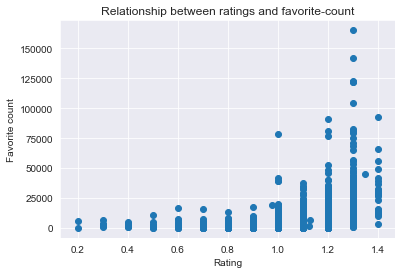

In [57]:
plt.scatter(df.rating, df.fav)
plt.title("Relationship between ratings and favorite-count")
plt.ylabel("Favorite count")
plt.xlabel("Rating");

> We use simple linear regression model to interprete this result (even though it may not be the best way.)

In [58]:
df["intercept"] = 1.
lm = sm.OLS(df.fav, df[["intercept","rating"]])
results = lm.fit()
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                    fav   R-squared:                       0.178
Model:                            OLS   Adj. R-squared:                  0.177
Method:                 Least Squares   F-statistic:                     355.2
Date:                Fri, 12 Oct 2018   Prob (F-statistic):           7.00e-72
Time:                        10:33:07   Log-Likelihood:                -17804.
No. Observations:                1645   AIC:                         3.561e+04
Df Residuals:                    1643   BIC:                         3.562e+04
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
intercept  -2.589e+04   1885.466    -13.729      0.000   -2.96e+04   -2.22e+04
rating      3.236e+04   1716.991     18.846      0.000     2.9e+04    3.57e+04
==============================================================================
Omnibus:                     1648.536   Durbin-Watson:                   1.691
Prob(Omnibus):                  0.000   Jarque-Bera (JB):           101955.703
Skew:                           4.749   Prob(JB):                         0.00
Kurtosis:                      40.381   Cond. No.                         12.6
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

> Even though this suggests that there is a positive correlationship between rating result and favorite accounts, R-squared value(0.178) tells us that there may be a better way to understand this realtionship.

### The best tweet which is extermely popular
> We take a look at the tweet which had extermely popularity

In [59]:
best_tweet = df[df.fav == df.fav.max()]
best_tweet

tweet_id           timestamp                         source  \
139  744234799360020481 2016-06-18 18:26:18  <a href="http://twitter.co...   

                              text                  expanded_urls  rating  \
139  Here's a doggo realizing y...  https://twitter.com/dog_ra...     1.3   

     stage    ret     fav                        jpg_url  img_num  \
139  doggo  84426  165057  https://pbs.twimg.com/ext_...        1   

               dog_type  intercept  
139  Labrador_retriever        1.0

In [60]:
pd.options.display.max_colwidth = 150
best_tweet.text

139    Here's a doggo realizing you can stand in a pool. 13/10 enlightened af (vid by Tina Conrad) https://t.co/7wE9LTEXC4
Name: text, dtype: object

> I checked the tweet visulally by jumping to the link, but what I have found was just a movie in which a dog is swimming in the pool. It may be said that an ordinary tweet sometimes attracts enormous attention unexpectedly. 

### Answer2. Relationship between favorite counts and the ratings
 
*  There is a positive correlationship between rating result and favorite accounts.
*  This relationship is not completely explained by a linear model.

<a id='conclusions'></a>
# Conclusions

>In this analysis, we focused on the tweet data from a dog-rating twitter account. We began from getting data from api. Then we cleaned and finally analyzed the data. 
>
>We found that some some dog stages and types get higher ratings from the account. Favorite count, which is a great indicater of the popularity of tweets, tend to be more for the tweets which are more highly evaluated. However, it is not sure whether more readers favored because they found that the tweet had higher rating, or because pictures themselves are wonderful worth great rating. 

<a id='reference'></a>
# Reference

* tweet data of "WeRateDogs (@dog_rates)" from https://twitter.com/dog_rates
* 'image_predictions.tsv' file from "https://d17h27t6h515a5.cloudfront.net/topher/2017/August/599fd2ad_image-predictions/image-predictions.tsv"